In [2]:
import pandas as pd
import numpy as np
import basketball_reference_scraper
from basketball_reference_scraper.players import get_stats, get_game_logs
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn 
from plotly.offline import init_notebook_mode,iplot
import plotly.graph_objects as go
init_notebook_mode(connected=True)

In [19]:
train_df = pd.read_csv('train.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FA5A469DD8>,
      dtype=object)

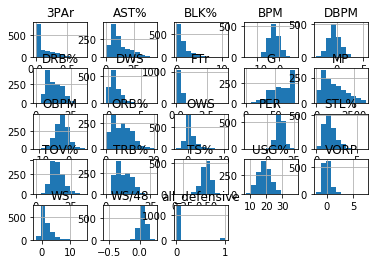

In [20]:
train_df.hist()

In [4]:
#correlation
correlation = train_df.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)
#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Magma",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )
layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )
data = [trace]
fig = go.Figure(data=data,layout=layout)
fig

In [8]:
corrMatrix = train_df.corr()
corrMatrix = corrMatrix.iloc[len(corrMatrix)-1]
corrMatrix.sort_values(ascending=False)

all_defensive    1.000000
DWS              0.350523
VORP             0.328588
WS               0.288926
BPM              0.270716
DBPM             0.270256
MP               0.216157
PER              0.201399
WS/48            0.180849
OWS              0.179812
BLK%             0.176460
OBPM             0.172178
G                0.152499
STL%             0.122479
TS%              0.122265
DRB%             0.096886
FTr              0.089087
TRB%             0.086938
TOV%             0.059663
ORB%             0.055365
AST%             0.045904
USG%             0.011750
3PAr            -0.031692
Name: all_defensive, dtype: float64

In [74]:
rf = RandomForestClassifier(n_estimators=300, max_depth=3)
X = train_df.copy().dropna()
Y = X['all_defensive']
X.drop(['all_defensive'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9495192307692307


In [75]:
metrics.confusion_matrix(y_test, y_pred)

array([[394,   0],
       [ 21,   1]], dtype=int64)

Data heavily imbalanced leading to a lot of false negatives. The training dataframe needs to be resampled. 

In [233]:
example_player_df = get_stats('Ben Simmons', stat_type='ADVANCED', playoffs=False, career=False)[0:1].drop(['TEAM', 'AGE', 'SEASON', 'LEAGUE', 'POS'], axis=1)
# rf.predict(example_player_df)

In [43]:
example_player_df = get_stats('Luka Dončić', stat_type='ADVANCED', playoffs=False, career=False)[0:1].drop(['TEAM', 'AGE', 'SEASON', 'LEAGUE', 'POS'], axis=1)
#rf.predict(example_player_df)

## Resampling

In [76]:
train_df['all_defensive'].value_counts()

0    1331
1      91
Name: all_defensive, dtype: int64

In [157]:
all_defense = train_df[train_df['all_defensive'] == 1]
not_all_defense = train_df[train_df['all_defensive'] == 0]

not_all_defense_downsampled = resample(not_all_defense, replace=False, n_samples = 120)
resampled_data = pd.concat([not_all_defense_downsampled, all_defense])

resampled_data['all_defensive'].value_counts()

0    120
1     91
Name: all_defensive, dtype: int64

In [132]:
rf = RandomForestClassifier(n_estimators=300, max_depth=3)
X = resampled_data.copy().dropna()
Y = X['all_defensive']
X.drop(['all_defensive'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state= 42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8064516129032258


In [79]:
metrics.confusion_matrix(y_test, y_pred)

array([[27,  7],
       [ 7, 21]], dtype=int64)

A lot less false negatives but now more false positives. Model tuning will have to be done to get a clearer picture as to whether this dataset is good.

In [48]:
example_player_df = get_stats('Ben Simmons', stat_type='ADVANCED', playoffs=False, career=False)[0:1].drop(['TEAM', 'AGE', 'SEASON', 'LEAGUE', 'POS'], axis=1)
rf.predict(example_player_df)

array([1], dtype=int64)

In [57]:
example_player_df = get_stats('Trae Young', stat_type='ADVANCED', playoffs=False, career=False)[0:1].drop(['TEAM', 'AGE', 'SEASON', 'LEAGUE', 'POS'], axis=1)
rf.predict(example_player_df)

array([0], dtype=int64)

A little sanity check to make sure the model has improved from classifying everything as non defensive. 

## Model tuning

In [133]:
rf = RandomForestClassifier(n_estimators=300, max_depth=3)
rfe = RFE(rf,10)
rfe = rfe.fit(X, Y)

In [134]:
selected_cols = [resampled_data.columns[i] for i in range(len(rfe.support_)) if rfe.support_[i] == True ]
selected_cols.append('all_defensive')
selected_cols

['BLK%',
 'BPM',
 'DBPM',
 'DRB%',
 'DWS',
 'FTr',
 'MP',
 'TOV%',
 'VORP',
 'WS',
 'all_defensive']

In [163]:
reduced_df = resampled_data.loc[:, selected_cols]
reduced_df.head(3)

,BLK%,BPM,DBPM,DRB%,DWS,FTr,TOV%,VORP,all_defensive,G,MP
1148,1.7,-1.6,-0.4,14.5,1.3,0.318,10.2,0.2,0,68.0,1719.0
144,0.5,-6.2,-1.6,8.0,0.1,0.277,14.5,-1.5,0,61.0,1418.0
357,0.5,-0.7,0.0,13.8,1.1,0.339,11.1,0.4,0,73.0,1384.0


In [82]:
rf = RandomForestClassifier(n_estimators=300, max_depth=3)
X = reduced_df.copy().dropna()
Y = X['all_defensive']
X.drop(['all_defensive'], axis=1, inplace=True)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7741935483870968


In [68]:
metrics.confusion_matrix(y_test, y_pred)

array([[30,  5],
       [ 6, 21]], dtype=int64)

In [156]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X, Y)
best_grid = grid_search.best_estimator_
grid_search.best_params_

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  5.2min finished


{'bootstrap': True,
 'max_depth': 90,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 300}

In [136]:
best_grid
y_pred = best_grid.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7741935483870968


## Direct Comparison

In [164]:
kfold = KFold(n_splits=3, shuffle=True, random_state=5)
scoring = 'accuracy'

In [165]:
#Resampled without hypyerparameter tuning
rf = RandomForestClassifier(n_estimators=300, max_depth=3)
X = resampled_data.copy().dropna()
Y = X['all_defensive']
X.drop(['all_defensive'], axis=1, inplace=True)
print(cross_val_score(rf, X, Y, cv=kfold, scoring=scoring).mean())

0.763388937664618


In [166]:
#Reduced feature set 
rf = RandomForestClassifier(n_estimators=300, max_depth=3)
X = reduced_df.copy().dropna()
Y = X['all_defensive']
X.drop(['all_defensive'], axis=1, inplace=True)

print(cross_val_score(rf, X, Y, cv=kfold, scoring=scoring).mean())

0.7647058823529411


In [167]:
#Best hyperparameters 
rf = RandomForestClassifier(bootstrap= True,max_depth= 90,min_samples_leaf=5,min_samples_split=8,n_estimators=300)
X = reduced_df.copy().dropna()
Y = X['all_defensive']
X.drop(['all_defensive'], axis=1, inplace=True)

print(cross_val_score(rf, X, Y, cv=kfold, scoring=scoring).mean())

0.7696078431372548


In [156]:
rf.fit(X,Y)
modified_cols = selected_cols.copy()
modified_cols.remove('all_defensive')
rf.predict_proba(example_player_df.loc[:, modified_cols])

array([[0.18807602, 0.81192398]])

## Investigating Scaling Data

In [168]:
from sklearn.preprocessing import StandardScaler
#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(train_df.loc[:, train_df.columns[:22]])
scaled = pd.DataFrame(scaled,columns=train_df.columns[:22])
scaled['all_defensive'] = train_df['all_defensive']
scaled.head(2)

,3PAr,AST%,BLK%,BPM,DBPM,DRB%,DWS,FTr,G,MP,...,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,all_defensive
0,0.855687,-0.229811,-0.143009,-0.740410,-0.859012,-0.089222,-0.392525,-0.047986,1.049676,1.508734,...,-0.954351,-0.836543,-0.594931,-0.535039,-0.516167,-0.502529,-1.788873,-0.990246,-1.076079,0
1,1.850509,0.881643,-0.076121,-0.338413,0.861678,-0.783910,0.491006,1.286734,0.645417,0.422779,...,-0.898719,0.283448,0.090570,-1.075115,-0.460730,-0.600038,-0.706145,0.001174,-0.056401,0


In [169]:
all_defense = scaled[scaled['all_defensive'] == 1]
not_all_defense = scaled[scaled['all_defensive'] == 0]

not_all_defense_downsampled = resample(not_all_defense, replace=False, n_samples = 120)
scaled_resampled_data = pd.concat([not_all_defense_downsampled, all_defense])


In [170]:
scaled_reduced_df = scaled_resampled_data.loc[:, selected_cols]

In [171]:
rf = RandomForestClassifier(n_estimators=300, max_depth=3)
X = scaled_reduced_df.copy().dropna()
Y = X['all_defensive']
X.drop(['all_defensive'], axis=1, inplace=True)

print(cross_val_score(rf, X, Y, cv=kfold, scoring=scoring).mean())

0.701974992895709


## Selection

In [21]:
best_model = RandomForestClassifier(bootstrap= True,max_depth= 90,min_samples_leaf=5,min_samples_split=8,n_estimators=300)
X = reduced_df.copy().dropna()
Y = X['all_defensive']
X.drop(['all_defensive'], axis=1, inplace=True)

best_model.fit(X,Y)
pickle.dump( best_model, open( "rf_model.p", "wb" ) )

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=90, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
best_model.predict(predict_df)

array([0, 0], dtype=int64)

Some next steps would be to further explore other models and implement a model zoo which should help with predictions. 

In [55]:
model = pickle.load( open( "rf_model.p", "rb" ))
rookie_dataframe = get_stats('Deandre Ayton', stat_type='ADVANCED', playoffs=False, career=False)
input_features = ['BLK%','BPM','DBPM','DRB%','DWS','FTr','G', 'MP','TOV%','VORP']
predict_df = rookie_dataframe.loc[:, input_features]

In [58]:
int(model.predict_proba(predict_df.loc[1:1])[0][1]*100)

35